In [1]:
import sys 
sys.path.append('..')
import random
from PIL import Image
import requests
from utils import *
import yaml
from diffusers.utils import load_image, make_image_grid 
import numpy as np 
from ultralytics import YOLO
from scripts.sam_results import SAMResults
from datasets import load_dataset
import random

yaml_file = "../configs/fashion_people_detection.yml"
with open(yaml_file, "r") as f:
    config = yaml.safe_load(f)

labels_dict = config.get("names")
labels_dict_reversed = {v: k for k, v in labels_dict.items()}

In [2]:
def unload(result):
    masks = result.masks.data
    boxes = result.boxes.xyxy
    scores = result.boxes.conf

    labels = result.boxes.cls
    labels = [int(label.item()) for label in labels]
    phrases = [labels_dict[label] for label in labels]
    return masks, boxes, scores, phrases

In [3]:
dataset_id = "jordandavis/fashion_people_detections"

ds = load_dataset(dataset_id, split='train', trust_remote_code=True, cache_dir='../hf_cache')

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/24 [00:00<?, ?it/s]

In [24]:
model_path = "/workspace/SEGMENT/human_parsing_new/train/weights/best.pt"
model = YOLO(model_path, task="segment")

Row Num: 13712


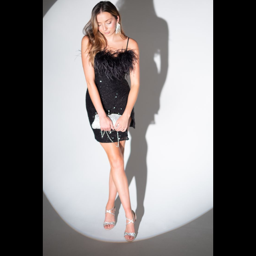

In [25]:
row_num = random.randint(0, len(ds))

row_num = 13712

print(f"Row Num: {row_num}")
row = ds[row_num]
image = row["image"]
image = resize_image_pil(image, 640)
image.resize((256, 256))

In [26]:
imgsz = max(image.size)

results = model(image, retina_masks=True, imgsz=imgsz)
result = results[0]


0: 640x640 1 hair, 1 face, 1 neck, 2 arms, 2 hands, 1 leg, 2 foots, 1 outfit, 1 phone, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


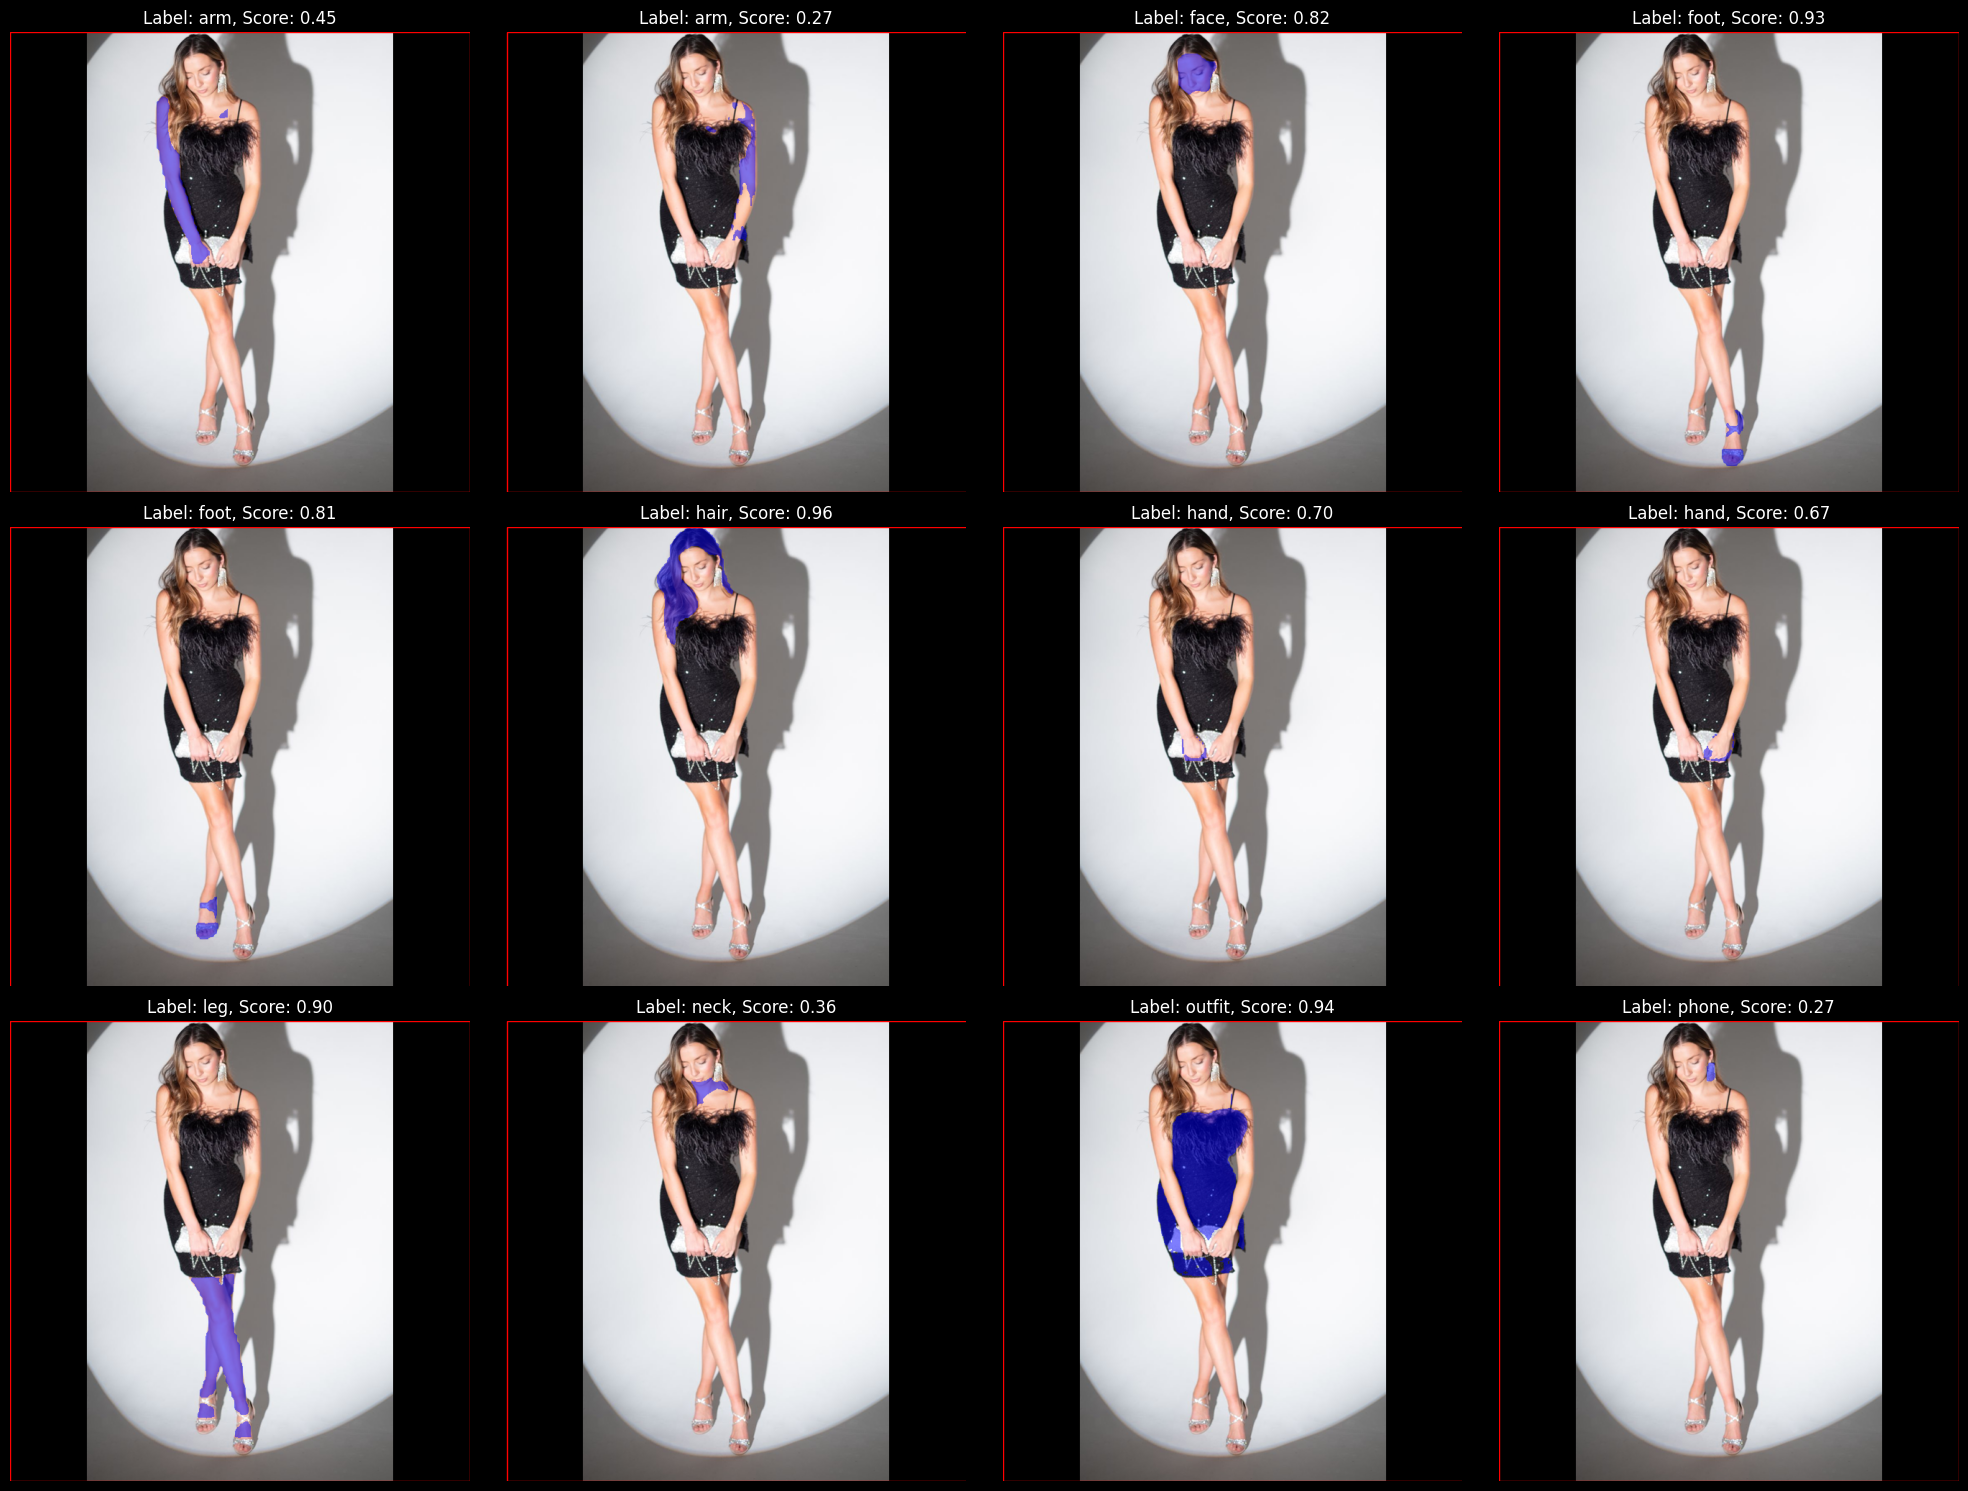

In [27]:
masks, boxes, scores, phrases = unload(result)
r = SAMResults(image, labels_dict_reversed, masks=masks, boxes=boxes, scores=scores, phrases=phrases, person_masks_only=False )
r.display_results()

In [13]:
# row = r.get_mask("phone")[0]
# box = row.get('box')
# mask = row.get("mask")
# overlay = overlay_mask(image, mask, opacity=0.9)
# overlay.crop(box).resize((512,512))